In [58]:
#Importing Packages
import arviz as az
import xarray as xr
import numpy as np
import skgstat as skg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyproj import Transformer
import geopandas as gpd

In [2]:
base_path = '/home/jez/Bias_Correction/'
path = f'{base_path}data/ProcessedData/NST_Observations.nc'
subset_path = f'{base_path}data/ProcessedData/NST_Observations_Subset.nc'
ds = xr.load_dataset(path)
ds_subset = xr.load_dataset(subset_path)

In [3]:
# Create grid coordinates that are Euclidean
rotated_coord_system = ccrs.RotatedGeodetic(
    13.079999923706055,
    0.5199999809265137,
    central_rotated_longitude=180.0,
    globe=None,
)

lon=ds_subset["Lon(째C)"]
lat=ds_subset["Lat(째C)"]

transformer = Transformer.from_crs("epsg:4326", rotated_coord_system)
glat,glon = transformer.transform(lat,lon)

ds_subset = ds_subset.assign_coords(grid_longitude=("Station_Lower", glon))
ds_subset = ds_subset.assign_coords(grid_latitude=("Station_Lower", glat))

In [59]:
antarctica_gdf = gpd.read_file(
    f"{base_path}data/Antarctica_Shapefile/antarctica_shapefile.shp"
)

antarctica_gdf = antarctica_gdf.to_crs(rotated_coord_system)

In [32]:
ds_subset['Mean Temperature'] = ds_subset['Temperature()'].sel(Month=1).mean(['Year','Day'])
ds_subset['Variance Temperature'] = ds_subset['Temperature()'].sel(Month=1).var(['Year','Day'])

/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [120]:
ds_subset['Mean Temperature 2000'] = ds_subset['Temperature()'].sel(Month=1,Year=2000).mean(['Day'])
ds_subset['Variance Temperature 2000'] = ds_subset['Temperature()'].sel(Month=1,Year=2000).var(['Day'])

/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


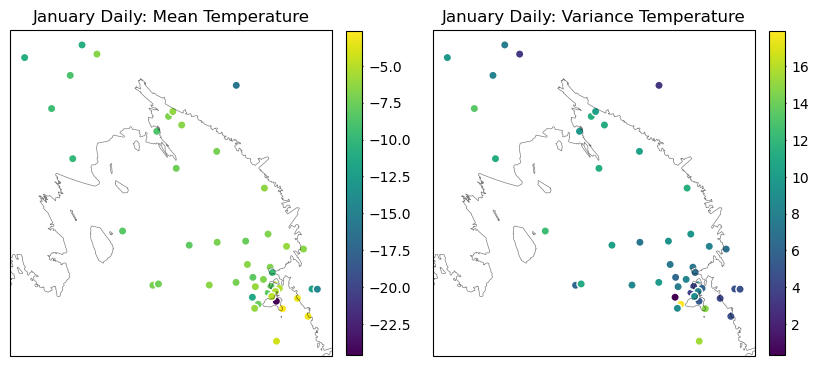

In [51]:
#Plotting Observational Data Mean Temperature
map_proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0, globe=None)
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": map_proj}, figsize=(10, 10))
plots=[]
params = ['Mean Temperature','Variance Temperature']

for param,ax in zip(params,axs):
    plots.append(ds_subset[params].plot.scatter(x="Lon(째C)",y="Lat(째C)",transform=ccrs.PlateCarree(),ax=ax,add_colorbar=False,hue=param))
    ax.coastlines(alpha=0.5,linewidth=0.5)
    ax.set_title(f"January Daily: {param}")
for plot, ax in zip(plots, axs.ravel()):
    cbar = fig.colorbar(plot, ax=ax,fraction=0.046, pad=0.04)
    cbar.ax.tick_params(size=1)

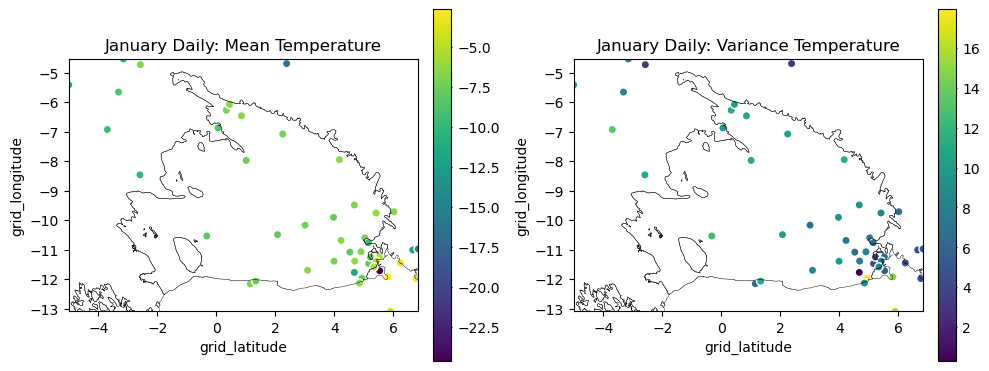

In [82]:
#Plotting Observational Data Mean Temperature
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
plots=[]
params = ['Mean Temperature','Variance Temperature']

for param,ax in zip(params,axs):
    plots.append(ds_subset[params].plot.scatter(x="grid_latitude",y="grid_longitude",ax=ax,add_colorbar=False,hue=param))
    min_x,max_x = ds_subset["grid_latitude"].min(),ds_subset["grid_latitude"].max()
    min_y,max_y = ds_subset["grid_longitude"].min(),ds_subset["grid_longitude"].max()
    ax.set_xlim([min_x,max_x])
    ax.set_ylim([min_y,max_y])
    # ax.set_aspect(abs((max_x-min_x)/(max_y-min_y)))
    ax.set_title(f"January Daily: {param}")
for plot, ax in zip(plots, axs.ravel()):
    cbar = fig.colorbar(plot, ax=ax,fraction=0.046, pad=0.04)
    cbar.ax.tick_params(size=1)
    antarctica_gdf.boundary.plot(ax=ax, color="k", linewidth=0.3)
plt.tight_layout()

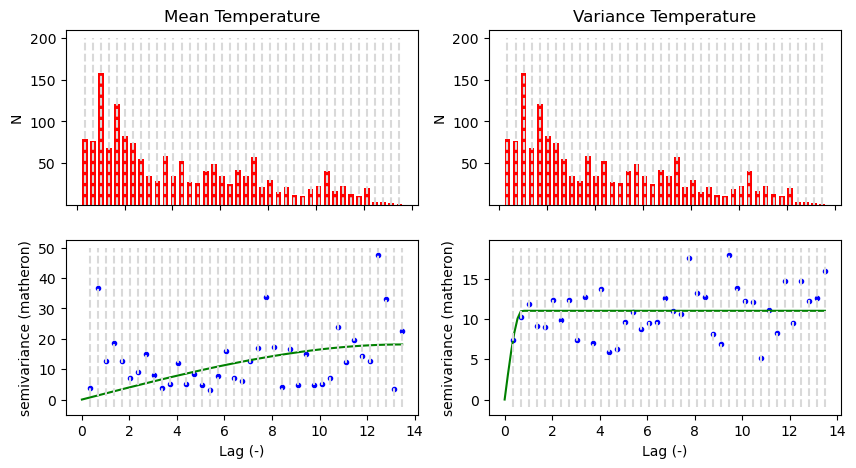

In [96]:
#Plot Semivariograms for Parameters
fig, axs = plt.subplots(2,2,figsize=(10,5))

params = ['Mean Temperature','Variance Temperature']
for param in params:
    da = ds_subset[param].dropna('Station_Lower')
    x,y = da.grid_latitude,da.grid_longitude
    coords = np.dstack([x,y]).reshape(-1,2)
    semivariogram = skg.Variogram(coords, da.data,n_lags=40)
    semivariogram.plot(axes=axs[:,params.index(param)][::-1])
    axs[:,params.index(param)][0].set_title(param)
plt.show()

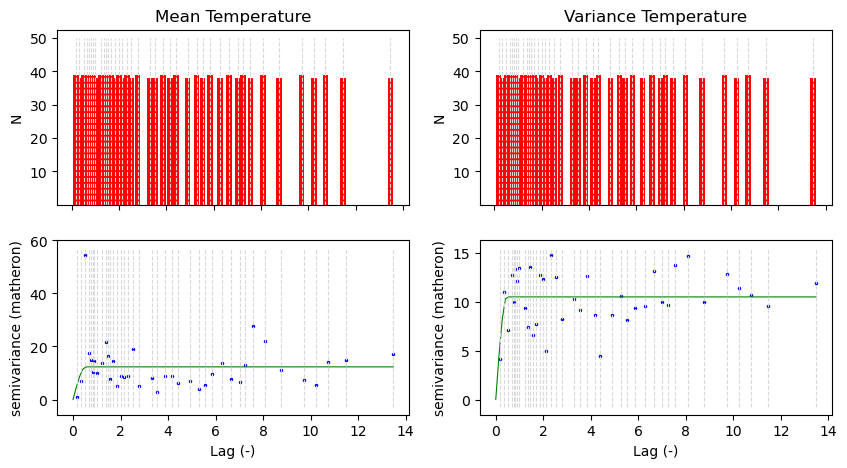

In [116]:
#Plot Semivariograms for Parameters
fig, axs = plt.subplots(2,2,figsize=(10,5))

params = ['Mean Temperature','Variance Temperature']
for param in params:
    da = ds_subset[param].dropna('Station_Lower')
    x,y = da.grid_latitude,da.grid_longitude
    coords = np.dstack([x,y]).reshape(-1,2)
    semivariogram = skg.Variogram(coords, da.data,n_lags=40,bin_func='uniform')
    semivariogram.plot(axes=axs[:,params.index(param)][::-1])
    axs[:,params.index(param)][0].set_title(param)
plt.show()

In [114]:
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.8

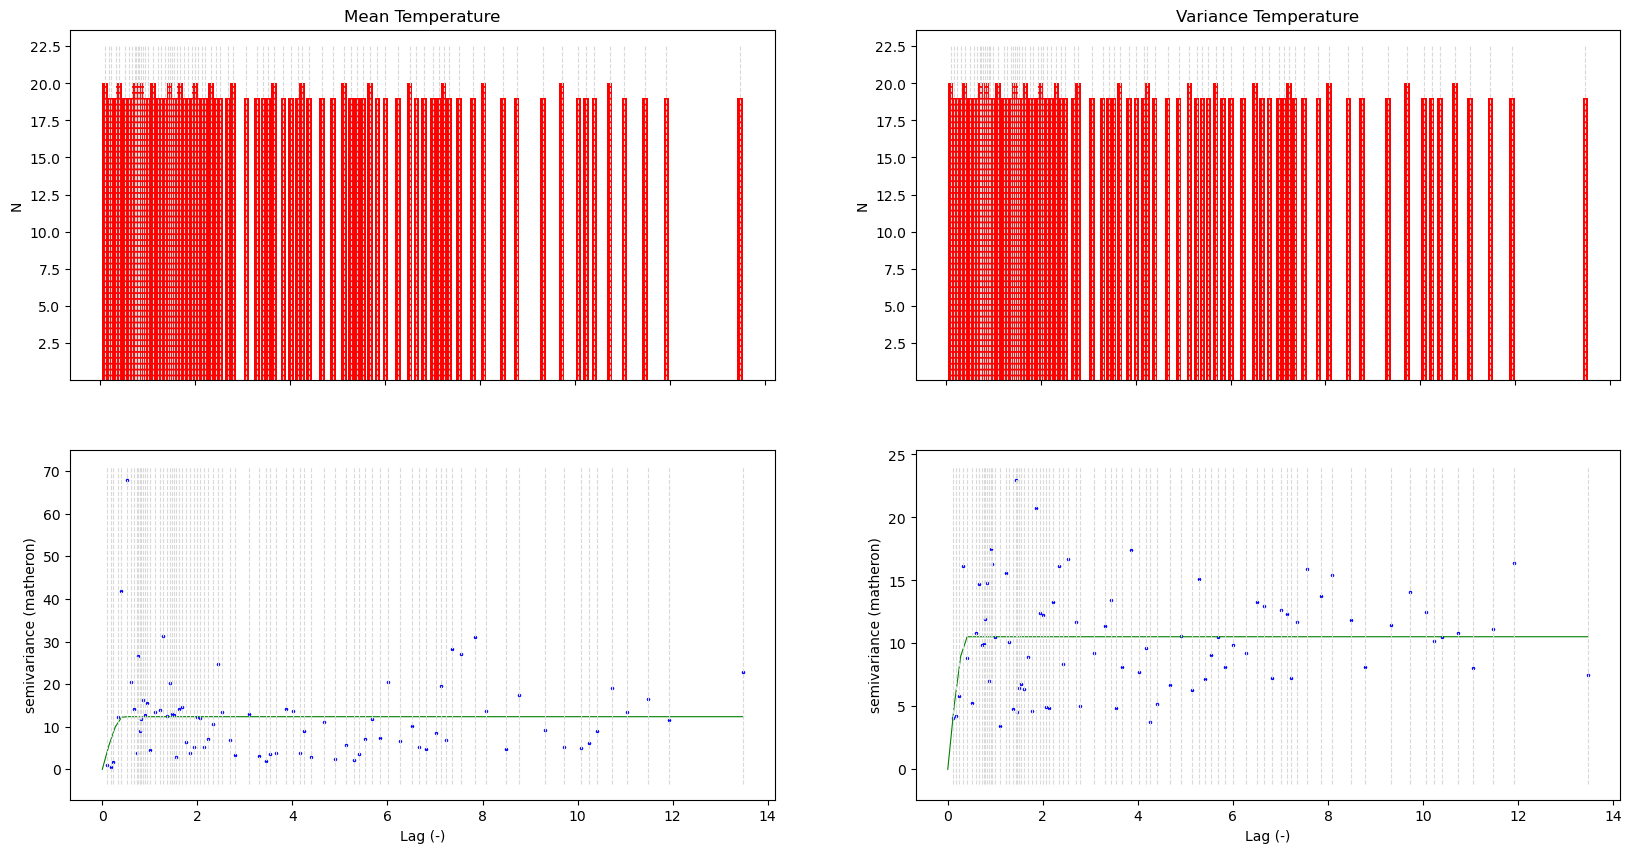

In [115]:
#Plot Semivariograms for Parameters
fig, axs = plt.subplots(2,2,figsize=(20,10))

params = ['Mean Temperature','Variance Temperature']
for param in params:
    da = ds_subset[param].dropna('Station_Lower')
    x,y = da.grid_latitude,da.grid_longitude
    coords = np.dstack([x,y]).reshape(-1,2)
    semivariogram = skg.Variogram(coords, da.data,n_lags=80,bin_func='uniform')
    semivariogram.plot(axes=axs[:,params.index(param)][::-1])
    axs[:,params.index(param)][0].set_title(param)
plt.show()

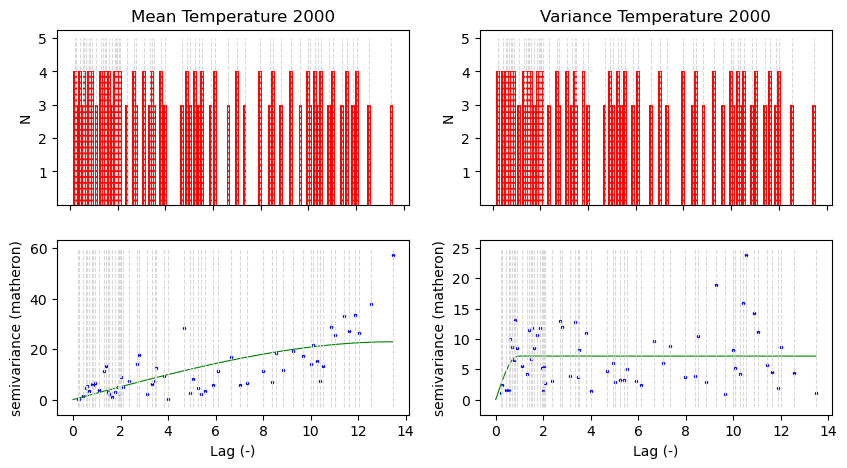

In [126]:
#Plot Semivariograms for Parameters
fig, axs = plt.subplots(2,2,figsize=(10,5))

params = ['Mean Temperature 2000','Variance Temperature 2000']
for param in params:
    da = ds_subset[param].dropna('Station_Lower')
    x,y = da.grid_latitude,da.grid_longitude
    coords = np.dstack([x,y]).reshape(-1,2)
    semivariogram = skg.Variogram(coords, da.data,n_lags=60,bin_func='uniform')
    semivariogram.plot(axes=axs[:,params.index(param)][::-1])
    axs[:,params.index(param)][0].set_title(param)
plt.show()